## Install the necessary libraries


In [2]:
%%capture
! pip install tqdm boto3 requests regex sentencepiece sacremoses
! pip install transformers

## BERT Features

In this part, you will use BERT features to classify DBPedia articles.
The data is already pre-processed, and the data loader is implemented below.

In [3]:
# Basics: dataset, data loaders, Classifier
import collections
import json
import torch
import torch.nn as nn
import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel


SPLITS = ['train', 'dev', 'test']

class DBPediaDataset(Dataset):
  '''DBPedia dataset.
    Args:
      path[str]: path to the original data.
  '''
  def __init__(self, path):
    with open(path) as fin:
      self._data = [json.loads(l) for l in fin]
    self._n_classes = len(set([datum['label'] for datum in self._data]))

  def __getitem__(self, index):
    return self._data[index]

  def __len__(self):
    return len(self._data)

  @property
  def n_classes(self):
    return self._n_classes

  @staticmethod
  def collate_fn(tokenizer, device, batch):
    '''The collate function that compresses a training batch.
      Args:
        batch[list[dict[str, Any]]]: data in the batch.
      Returns:
        labels[torch.LongTensor]: the labels in the batch.
        sentences[dict[str, torch.Tensor]]: sentences converted by tokenizers.
    '''
    labels = torch.tensor([datum['label'] for datum in batch]).long().to(device)
    sentences = tokenizer(
        [datum['sentence'] for datum in batch],
        return_tensors='pt',  # pt = pytorch style tensor
        padding=True)
    for key in sentences:
      sentences[key] = sentences[key].to(device)
    return labels, sentences

def construct_datasets(prefix, batch_size, tokenizer, device):
  '''Constructs datasets and data loaders.
    Args:
      prefix[str]: prefix of the dataset (e.g., dbpedia_).
      batch_size[int]: maximum number of examples in a batch.
      tokenizer: model tokenizer that converts sentences to integer tensors.
      device[torch.device]: the device (cpu/gpu) that the tensor should be on.
    Returns:
      datasets[dict[str, Dataset]]: a dict of constructed datasets.
      dataloaders[dict[str, DataLoader]]: a dict of constructed data loaders.
  '''
  datasets = collections.defaultdict()
  dataloaders = collections.defaultdict()
  for split in SPLITS:
    datasets[split] = DBPediaDataset(f'{prefix}{split}.json')
    dataloaders[split] = DataLoader(
        datasets[split],
        batch_size=batch_size,
        shuffle=(split == 'train'),
        collate_fn=lambda x:DBPediaDataset.collate_fn(tokenizer, device, x))
  return datasets, dataloaders

In [4]:
# 1.1: [CODE] put your implementation of classifer here
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes):
        super(Classifier, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_classes),
        )
    def forward(self, input):
        out = self.stack(input)
        return out

## Training and Evaluation

In [5]:
# hyperparameters
batch_size = 32
classifier_hidden_size = 32
# hyperparameters ends

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
datasets, dataloaders = construct_datasets(
    prefix='dbpedia_',
    batch_size=batch_size,
    tokenizer=tokenizer,
    device=bert_model.device)

classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()
# 1.1: [CODE] train your classifier here
def train(seed_val):
    total_correct = 0.
    total_samples = 0.
    pbar = tqdm.tqdm(dataloaders['train'])
    #initialize random seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_val)
    else:
        torch.manual_seed(seed_val)
    for labels, sentences in pbar:
        with torch.no_grad():
            unpooled_features = bert_model(**sentences)['last_hidden_state'] # [B, L, D]
        output = classifier(unpooled_features[:, 0, :])
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, predicted = torch.max(output, 1)
        total_correct += float((predicted == labels.type_as(predicted)).sum())
        total_samples += labels.size(0)

    return total_correct/total_samples

  # 1.1: [CODE] ends here
  # Note: you can re-use this code snippet for 1.2 as well

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [31]:
acc = train(45)
print("\n", acc)

100%|██████████| 313/313 [00:40<00:00,  7.66it/s]


 0.975


In [32]:
def test(seed_val):
    total_correct = 0.
    total_samples = 0.
    pbar = tqdm.tqdm(dataloaders['test'])
    #initialize random seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_val)
    else:
        torch.manual_seed(seed_val)
    for labels, sentences in pbar:
        with torch.no_grad():
            unpooled_features = bert_model(**sentences)['last_hidden_state'] # [B, L, D]
        output = classifier(unpooled_features[:, 0, :])
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, predicted = torch.max(output, 1)
        total_correct += float((predicted == labels.type_as(predicted)).sum())
        total_samples += labels.size(0)

    return total_correct/total_samples

In [33]:
acc = test(45)
print("\n", acc)

100%|██████████| 32/32 [00:03<00:00,  9.19it/s]


 0.988


In [36]:
acc2 = train(12)
print("\n", acc2)

100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


 0.976


In [12]:
acc3 = train(33)
print("\n", acc3)

100%|██████████| 313/313 [00:41<00:00,  7.49it/s]


 0.7787


In [37]:
acc4 = train(127)
print("\n", acc4)

100%|██████████| 313/313 [00:42<00:00,  7.44it/s]


 0.9825


In [13]:
acc5= train(5)
print("\n", acc2)

100%|██████████| 313/313 [00:41<00:00,  7.50it/s]


 0.7625


For the 5 experiments above the mean accuracy is 0.89494 and the standard deviation is 0.1136872596. The best accuracy on the test set was 0.988 (this took a lot of tries with different seeds).

In [13]:
# 1.2
def mean_train(seed_val):
    total_correct = 0.
    total_samples = 0.
    pbar = tqdm.tqdm(dataloaders['train'])
    #initialize random seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_val)
    else:
        torch.manual_seed(seed_val)
    for labels, sentences in pbar:
        with torch.no_grad():
            unpooled_features = bert_model(**sentences)['last_hidden_state'] # [B, L, D]

        attention = (sentences['attention_mask'].unsqueeze(-1)).expand(unpooled_features.size())
        masked_features = attention*(unpooled_features)
        mean_features = torch.sum(masked_features, dim=1) / torch.clamp(attention.sum(dim=1), min=1e-9)
        output = classifier(mean_features)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, predicted = torch.max(output, 1)
        total_correct += float((predicted == labels.type_as(predicted)).sum())
        total_samples += labels.size(0)

    return total_correct/total_samples


In [14]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

In [16]:
macc = mean_train(19)
print("\n", macc)

100%|██████████| 313/313 [00:44<00:00,  7.05it/s]


 0.9658


In [17]:
def mean_test(seed_val):
    total_correct = 0.
    total_samples = 0.
    pbar = tqdm.tqdm(dataloaders['test'])
    #initialize random seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_val)
    else:
        torch.manual_seed(seed_val)
    for labels, sentences in pbar:
        with torch.no_grad():
            unpooled_features = bert_model(**sentences)['last_hidden_state'] # [B, L, D]

        attention = (sentences['attention_mask'].unsqueeze(-1)).expand(unpooled_features.size())
        masked_features = attention*(unpooled_features)
        mean_features = torch.sum(masked_features, dim=1) / torch.clamp(attention.sum(dim=1), min=1e-9)
        output = classifier(mean_features)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, predicted = torch.max(output, 1)
        total_correct += float((predicted == labels.type_as(predicted)).sum())
        total_samples += labels.size(0)

    return total_correct/total_samples

In [18]:
acc = mean_test(19)
print("\n", acc)

100%|██████████| 32/32 [00:03<00:00,  8.25it/s]


 0.979


In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

macc2 = mean_train(131)
print("\n", macc2)

100%|██████████| 313/313 [00:46<00:00,  6.70it/s]


 0.7577


In [20]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

macc = mean_train(49)
print("\n", macc)

100%|██████████| 313/313 [00:45<00:00,  6.95it/s]


 0.965


In [18]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

macc = mean_train(127)
print("\n", macc)

100%|██████████| 313/313 [00:43<00:00,  7.22it/s]


 0.8012


In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

macc = mean_train(137)
print("\n", macc)

100%|██████████| 313/313 [00:43<00:00,  7.23it/s]


 0.8133


The mean is 0.8606, and the standard deviation is 0.0978. The accuracy on the test set is 0.979.

In [21]:
def max_train(seed_val):
    total_correct = 0.
    total_samples = 0.
    pbar = tqdm.tqdm(dataloaders['train'])
    #initialize random seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_val)
    else:
        torch.manual_seed(seed_val)
    for labels, sentences in pbar:
        with torch.no_grad():
            unpooled_features = bert_model(**sentences)['last_hidden_state'] # [B, L, D]
        attention = sentences['attention_mask'].unsqueeze(-1).expand(unpooled_features.size())
        masked_features = attention*(unpooled_features)
        max_features, _ = torch.max(masked_features, dim=1)
        output = classifier(max_features)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, predicted = torch.max(output, 1)
        total_correct += float((predicted == labels.type_as(predicted)).sum())
        total_samples += labels.size(0)

    return total_correct/total_samples

In [32]:
def max_test(seed_val):
    total_correct = 0.
    total_samples = 0.
    pbar = tqdm.tqdm(dataloaders['test'])
    #initialize random seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_val)
    else:
        torch.manual_seed(seed_val)
    for labels, sentences in pbar:
        with torch.no_grad():
            unpooled_features = bert_model(**sentences)['last_hidden_state'] # [B, L, D]
        attention = sentences['attention_mask'].unsqueeze(-1).expand(unpooled_features.size())
        masked_features = attention*(unpooled_features)
        max_features, _ = torch.max(masked_features, dim=1)
        output = classifier(max_features)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, predicted = torch.max(output, 1)
        total_correct += float((predicted == labels.type_as(predicted)).sum())
        total_samples += labels.size(0)

    return total_correct/total_samples

In [26]:
macc = max_train(21)
print("\n", macc)

100%|██████████| 313/313 [00:46<00:00,  6.78it/s]


 0.8644


In [25]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

macc = max_train(19)
print("\n", macc)

100%|██████████| 313/313 [00:46<00:00,  6.76it/s]


 0.8103


In [29]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

macc = max_train(189)
print("\n", macc)

100%|██████████| 313/313 [00:45<00:00,  6.94it/s]


 0.8928


In [30]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

macc = max_train(657)
print("\n", macc)

100%|██████████| 313/313 [00:46<00:00,  6.73it/s]


 0.9198


In [31]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
loss_func = nn.CrossEntropyLoss()

macc = max_train(176)
print("\n", macc)

100%|██████████| 313/313 [00:46<00:00,  6.79it/s]


 0.9349


In [33]:
macc = max_test(176)
print("\n", macc)

100%|██████████| 32/32 [00:04<00:00,  7.42it/s]


 0.95


The mean was 0.894, and the standard deviation was 0.0494. The accuracy on the test set is 0.95.

It seems like max > mean > cls in terms of accuracies.

In [34]:
def unf_train(seed_val):
    total_correct = 0.
    total_samples = 0.
    pbar = tqdm.tqdm(dataloaders['train'])
    #initialize random seed
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_val)
    else:
        torch.manual_seed(seed_val)
    for labels, sentences in pbar:
        unpooled_features = bert_model(**sentences)['last_hidden_state'] # [B, L, D]
        output = classifier(unpooled_features[:, 0, :])
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, predicted = torch.max(output, 1)
        total_correct += float((predicted == labels.type_as(predicted)).sum())
        total_samples += labels.size(0)

    return total_correct/total_samples

In [ ]:
bert_model.named_parameters

<bound method Module.named_parameters of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (d

In [35]:
# hyperparameters
batch_size = 32
classifier_hidden_size = 32
# hyperparameters ends

classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)

params = list()
for name, param in bert_model.named_parameters():
  if name.startswith('pooler'):
    params.append(param)
optimizer = torch.optim.Adam(params + list(classifier.parameters()), lr=5e-4)
loss_func = nn.CrossEntropyLoss()
# Finish your code here for 1.4. You may re-used most of your code for 1.1.

In [37]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
params = list()
for name, param in bert_model.named_parameters():
  if name.startswith('pooler'):
    params.append(param)
optimizer = torch.optim.Adam(params + list(classifier.parameters()), lr=5e-4)
loss_func = nn.CrossEntropyLoss()
unf_acc = unf_train(17)
print("\n", unf_acc)

100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


 0.9791


In [38]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
params = list()
for name, param in bert_model.named_parameters():
  if name.startswith('pooler'):
    params.append(param)
optimizer = torch.optim.Adam(params + list(classifier.parameters()), lr=5e-4)
loss_func = nn.CrossEntropyLoss()
unf_acc = unf_train(165)
print("\n", unf_acc)

100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 0.9834


In [41]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
params = list()
for name, param in bert_model.named_parameters():
  if name.startswith('pooler'):
    params.append(param)
optimizer = torch.optim.Adam(params + list(classifier.parameters()), lr=5e-4)
loss_func = nn.CrossEntropyLoss()
unf_acc = unf_train(167)
print("\n", unf_acc)

100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


 0.9638


In [43]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
params = list()
for name, param in bert_model.named_parameters():
  if name.startswith('pooler'):
    params.append(param)
optimizer = torch.optim.Adam(params + list(classifier.parameters()), lr=5e-4)
loss_func = nn.CrossEntropyLoss()
unf_acc = unf_train(178)
print("\n", unf_acc)

100%|██████████| 313/313 [01:54<00:00,  2.74it/s]


 0.9733


In [44]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')
if torch.cuda.is_available():  # use GPU if available
  bert_model = bert_model.cuda()
classifier = Classifier(
    bert_model.config.hidden_size,
    classifier_hidden_size,
    datasets['train'].n_classes).to(bert_model.device)
params = list()
for name, param in bert_model.named_parameters():
  if name.startswith('pooler'):
    params.append(param)
optimizer = torch.optim.Adam(params + list(classifier.parameters()), lr=5e-4)
loss_func = nn.CrossEntropyLoss()
unf_acc = unf_train(195)
print("\n", unf_acc)

100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


 0.7377


The mean is given by 0.927, and 0.0113 is the standard deviation.

**2**

**2.1** a. One possible interpretation of the sentence is to have the object of the sentence be "a cat with a telescope", which the girl is observing, or to take the telescope to be the instrument used by the girl in order to observe the cat.

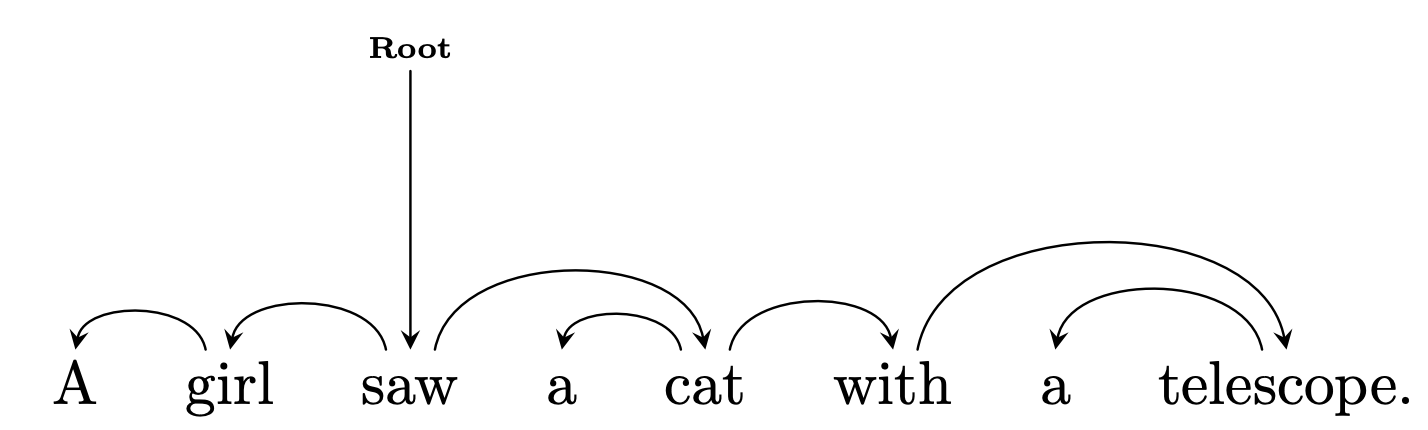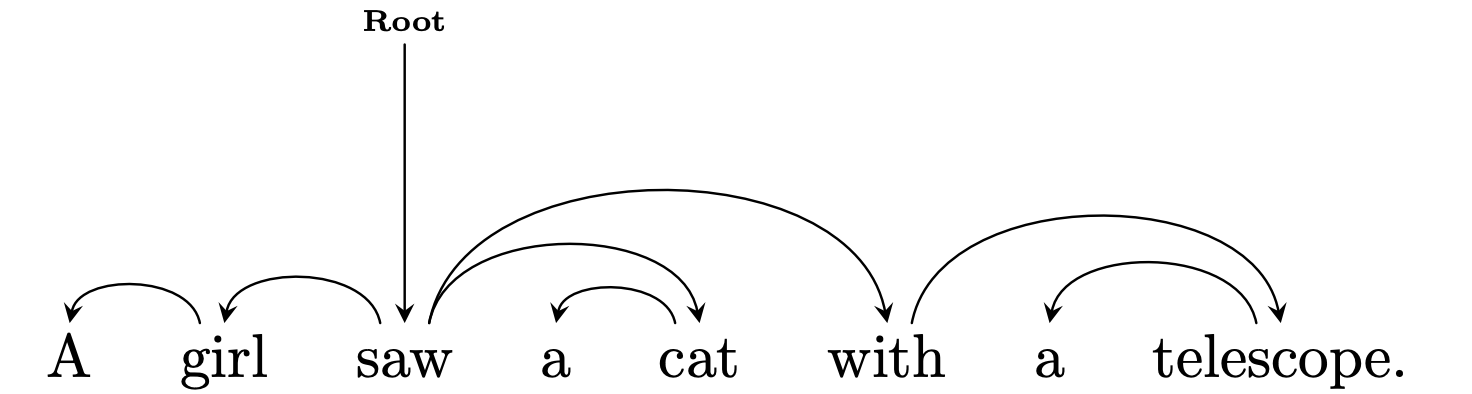

**c**. As we can see, both trees are projective

**d.** From the diagram above we can see that the number of words with correct head is for the second tree is 7 out 8 words, so $UAS = 7/8$.

**2.2**

**a**. We have that $$ \exp(s_{k}) = \exp(2\log k) = \left( \exp(log(k)) \right)^{2} = k^{2}, $$ and $$ \sum_{k=1}^{3}\exp(s_{k}) = \sum_{k=1}^{3} k^{2}.$$ Therefore we have that $$ p_{k} = \frac{k^{2}}{\sum_{k=1}^{3} k^{2}} = \frac{k^{2}}{14}.$$

Thus $p_{1} = 1/14, p_{2} = 2/7, p_{3} = 9/14$.

We have that $$p_{n} = \frac{\exp(s_{n})}{\sum_{k=1}^{n}\exp(s_{j})} = \frac{\exp(s_{n})}{\sum_{k=1}^{n}\exp(s_{j})}\cdot \frac{\exp(s_{n-1})}{\exp(s_{n-1})} = \exp(s_{n}-s_{n-1})\cdot p_{n-1}.$$

So $p_{n}=\exp(s_{n}-s_{n-1})\cdot p_{n-1}.$

**c.** It will become sharper since each exponential term will blow up at comparable speeds, thus making it harder to distinguish between each label, i.e. giving a flatter distribution.

**2.3**

**a.** An announcement was sent to every student.

**b.** No, the logical form does not mean that a single announcement was sent to all students. Since the operator $\forall s$ encloses the statement, it means that the existence of some announcement sent to a student is true for each, regardless of what that announcement is, *i.e.* it could very well be the case that each student is receiving a different announcement.

**2.4** a. We have that $$ l = \frac{1}{8}(-2log_{2}4) = -\frac{1}{2}.$$ There for the perplexity is $\frac{1}{\sqrt{2}}$.

b. Since $|X|=2$ and $p(x) = \frac{1}{|V|^{4}}$ since each word is uniformuly distributed, we then obtain that $$ l=\frac{1}{8}\left( \log_{2}\frac{1}{|V|^{4}} \right) =  -\frac{1}{2}\log_{2}|V|.$$ Therefore $ p = 2^{\frac{1}{2}\log_{2}|V|}.$